# Introduccion

En este notebook se muestran los experimentos de los mejores resultados obtenidos en al proyecto final del curso de Sistemas de Informacion en mi 5to ano de mi carrera de Ciencia de la Computacion. El proyecto consiste en la creacion de un sistema de clasificacion automatica para Revolico (<https://www.revolico.com>) el sitio web de clasificados mas grande de Cuba. Como ya explique solamente mostraremos los mejores experimentos que se llevaran a cabo sobre el dataset ya procesado. Para la creacion del dataset se utilizo una imagen del sitio web de Revolico en donde se encuentran todos los anuncios descargados (utilizando un *crawler*). Estos anuncios se ordenaron acorde a las subcategorias encontradas en el sitio, se eliminaron aquellos anuncios que se encontraban en mas de una categoria. El texto fue transformado a lower-case, ademas de eliminarse letras como la n, las vocales con tilde se cambiaron a vocales sin tilde, esto tras verificar que como resultado de la configuracion del teclado de muchas personas, las tildes no tienden a utilizarse y es necesario no diferenciar palabras iguales que alternen en su acentuacion. Otra tecnica realizada en el preprocesado fue la normalizacion de letras repetidas dos o mas veces, obviando secuancias como la ll, nn, etc las cuales se eliminan si ocurren tres o mas veces. Ademas en el proceso de preprocesado se eliminan numeros y palabras de tamano menor o igual que dos, se eliminan las *stopwords* y se *lematiza* el texto. El codigo relacionado a este proceso se encuentra en `utils.py`. El texto limpio es guardado en archivos JSON junto a la categoria a la que pertenece el mismo, estos archivos pueden explorarse en la carpeta `json cleaned 4`.

# Creacion de los feature vectors

Para la creacion de los vectores de caracteristicas se utilizo el metodo tradicional de la frecuencia de palabras (`word frecuency`) mas repetidas y las frecuancias [tf idf][1] de las mismas. El codigo completo puede ser visto en `feature_vecs.py`.
[1]: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [1]:
import json
import os
from typing import Union, List, Tuple, Dict
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import learning_curve, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt

El siguiente metodo dado el path al dataset cuenta las palabras devolviendo un diccionario de `palabras:frecuencia de aparicion en el dataset`.

In [2]:

def count_words(json_path: str) -> Dict[str, int]:
	counter: Dict[str, int] = {}
	file: os.DirEntry
	for file in os.scandir(json_path):
		if file.is_file() and not file.name.startswith('.') and \
			file.name.endswith('.json'):

			with open(file) as jfile:
				info: Dict[str, str] = json.load(jfile)
			for word in info['text']:
				try:
					counter[word] += 1
				except KeyError:
					counter[word] = 1

	return counter

El siguiente metodo devuelve las `count` palabras mas repetidas dado un diccionario de palabras con la cantidad de veces que estas se repiten y la cantidad de mas repetidas.

In [3]:
def most_rep(words: Dict[str, int], count: int):
	return [tup[0]
			for tup in sorted(list(words.items()), key=lambda x: x[1],
							  reverse=True)[:count]]

Carga el dataset a memoria en una lista de diccionarios

In [4]:
def load_data(json_path: str):
	info: List[Dict[str, str]] = []
	file: os.DirEntry
	for file in os.scandir(json_path):
		if file.is_file() and not file.name.startswith('.') and \
				file.name.endswith('.json'):
			with open(file) as jfile:
				info.append(json.load(jfile))
	return info

Elimina los anuncios repetidos en una misma categoria.

> Ejercicio: como tarea se puede dejar eliminar los repetidos en categorias distintas borrandolos completamente del dataset.

In [5]:
def clean_dataset2(dataset: List):
	'''
	Elimina los repetidos en la misma categoria, dejando solo uno
	'''
	rep = np.zeros(len(dataset))
	new_dataset = []
	for i in range(len(dataset)):
		if not rep[i]:
			for j in range(i + 1, len(dataset)):
				if dataset[i] == dataset[j]:
					rep[j] = 1

	for i in range(len(dataset)):
		if not rep[i]:
			new_dataset.append(dataset[i])

	return new_dataset

Crea el trainset y el testset, para ello carga los archivos del texto limpio que se encuentran en JSON, busca las `n_words` palabras mas repetidas, las cuales seran nuestro vocabulario, y 'ordena' de forma aleatoria el dataset. Nos quedamos con 5000 anuncios como parte del testset.

> Ejercicio: como ejercicio futuro puede quedar separar el testset y el trainset utilizando alguna tecnica *stratified* que garantice una representacion correcta de cada categoria en ambos sets.

In [6]:
def ma_lo_data_set(path: str, n_words: int) -> Tuple[Dict, Dict, Dict[str, int]]:
	'''
	 make, load and return the dataset from a structured data folder
	:param n_words: most important words number
	:type n_words: int
	:param path: path to dataset
	:type path: str
	:return:
	:rtype:
	'''
	word_counter = count_words(path)
	voc = most_rep(word_counter, n_words)

	data = load_data(path)
	np.random.shuffle(data)
	data = clean_dataset2(data)

	train_set, test_set = data[:-5000], data[-5000:]

	return train_set, test_set, voc

El siguiente metodo realiza la matriz de unigramas y bigramas.

In [7]:
def do_uni_bigram():
	'''
	 unigram and bigram matrix with k most repetitive words
	:return: the counter matrix for train set and the counter matrix for test
	 set
	:rtype:
	'''
	train_set, test_set, voc = ma_lo_data_set((r'./json cleaned 4/'),10000)

	counter_uni_bigram = CountVectorizer(ngram_range=(1, 2,))
	counter_uni_bigram.fit(voc)
	uni_bigram_matrix_train = counter_uni_bigram.transform(
		[' '.join(info['text']) for info in train_set])
	uni_bigram_matrix_test = counter_uni_bigram.transform(
		[' '.join(info['text']) for info in test_set])

	return uni_bigram_matrix_train, uni_bigram_matrix_test, [info['category']
		   for info in train_set], [info['category'] for info in test_set]

Partiendo de la matriz de frecuencia podemos hacer la de tf idf.

In [8]:
def tfidf_matrix(count_matrix):
	return TfidfTransformer().fit_transform(count_matrix)

# Decision Tree

Analisis del arbol de desicion. Primero que todo se crea la matriz de tfidf a partir de los unigramas y bigramas (representacion que vamos a utilizar por ser la que mejor a dado resultado en el estado del arte), los unigramas y bigramas no solo tienen la peculiaridad de que permiten mostrar aproximadamente la frecuencia de una palabra en el texto sino que ademas permite mostrar datos de la misma, o sea, datos como acentuacion, terminacion, genero, etc. estos datos de cirta forma quedan recogidos en los unigramas y bigramas de la palabra.

In [9]:
train_uni_bigram, test_uni_bigram, train_cats, test_cats = \
	do_uni_bigram()

tfidf_uni_bigram_train = tfidf_matrix(train_uni_bigram)
tfidf_uni_bigram_test = tfidf_matrix(test_uni_bigram)

Se crean algunas medidas que seran aplicadas posteriormente.

In [10]:
from sklearn.metrics import f1_score, make_scorer, precision_score, \
	accuracy_score, hamming_loss, jaccard_score, matthews_corrcoef, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

f1_scorer = make_scorer(f1_score, average='weighted')
precision_scorer = make_scorer(precision_score, average='weighted')
accuracy_scorer = make_scorer(accuracy_score)
hamming_losser = make_scorer(hamming_loss)
jaccard_scorer = make_scorer(jaccard_score, average='weighted')
matthews_corrcoef_scorer = make_scorer(matthews_corrcoef)
recall_scorer = make_scorer(recall_score, average='weighted')

El siguiente metodo es el encargado de dibujar las lineas de aprendizaje realizadas utilizando el crossvalidation.

In [11]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5),
						scorer=None):
	"""
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
	plt.figure()
	plt.title(title)

	if ylim is not None:
		plt.ylim(*ylim)

	plt.xlabel("Training examples")
	plt.ylabel("Score")

	train_sizes, train_scores, test_scores = learning_curve(
		estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
		scoring=scorer)

	train_scores_mean = np.mean(train_scores, axis=1)
	train_scores_std = np.std(train_scores, axis=1)
	test_scores_mean = np.mean(test_scores, axis=1)
	test_scores_std = np.std(test_scores, axis=1)

	plt.grid()

	plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
					 train_scores_mean + train_scores_std, alpha=0.1,
					 color="r")
	plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
					 test_scores_mean + test_scores_std, alpha=0.1, color="g")
	plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
			 label="Training score")
	plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
			 label="Cross-validation score")

	plt.legend(loc="best")
	plt.show()

Devuelve algunas metricas del clasificador *classifier* luego de ser entrenado.

In [12]:
def evaluate(classifier):
	train_uni_bigram, test_uni_bigram, train_cats, test_cats = \
		do_uni_bigram()

	tfidf_uni_bigram_train = tfidf_matrix(train_uni_bigram)
	tfidf_uni_bigram_test = tfidf_matrix(test_uni_bigram)

	classifier.fit(tfidf_uni_bigram_train, train_cats)
	pred_nb = classifier.predict(tfidf_uni_bigram_test)

	val_test_f1 = f1_score(test_cats, pred_nb, average='weighted')
	val_test_precision = precision_score(test_cats, pred_nb, average='weighted')
	val_test_accuracy = accuracy_score(test_cats, pred_nb)
	val_test_hamming_loss = hamming_loss(test_cats, pred_nb)
	val_test_jaccard_score = jaccard_score(test_cats, pred_nb, average='weighted')
	# val_test_log_loss = log_loss(test_cats, pred_nb)
	val_test_matthews_corrcoef = matthews_corrcoef(test_cats, pred_nb)
	val_test_recall_score = recall_score(test_cats, pred_nb, average='weighted')

	return val_test_f1, val_test_precision, val_test_accuracy, \
		   val_test_hamming_loss, val_test_jaccard_score, \
		   val_test_matthews_corrcoef, val_test_recall_score,

Metodo que alaniza el promedio de las metricas luego de aplicar 35 iteraiciones, util para comprobar que los resultados son estadisticamente correctos.

In [13]:
def statistical_average(classifier):
    test_f1 = 0
    test_precision = 0
    test_accuracy = 0
    test_hamming_loss = 0
    test_jaccard_score = 0
    test_matthews_corrcoef = 0
    test_recall_score = 0

    for time in range(35):
        results = evaluate(classifier)

        test_f1 += results[0]
        test_precision += results[1]
        test_accuracy += results[2]
        test_hamming_loss += results[3]
        test_jaccard_score += results[4]
        test_matthews_corrcoef += results[5]
        test_recall_score += results[6]

    print(f'f1 average: {test_f1 / 35}')
    print(f'precision average: {test_precision / 35}')
    print(f'accuracy average: {test_accuracy / 35}')
    print(f'hamming_loss average: {test_hamming_loss / 35}')
    print(f'jaccard_score average: {test_jaccard_score / 35}')
    print(f'matthews_corrcoef average: {test_matthews_corrcoef / 35}')
    print(f'recall_score average: {test_recall_score / 35}')

El siguiente metodo se encarga de hallar la media de la metrica *scoring* aplicada al crossvalidation.

In [14]:
def mean_cross_score(estimator, X, y=None, groups=None, scoring=None,
					 cv='warn', n_jobs=None, verbose=0, fit_params=None,
					 pre_dispatch='2*n_jobs', error_score='raise-deprecating'):

	scores: np.ndarray
	scores = cross_val_score(estimator=estimator, X=X, y=y, groups=groups,
						   scoring=scoring, cv=cv, n_jobs=n_jobs, 
						   verbose=verbose, fit_params=fit_params, 
						   pre_dispatch=pre_dispatch, error_score=error_score)
	return scores.mean()

Se crea el clasificador y se predicen los datos del testset para probarlo

In [15]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(tfidf_uni_bigram_train, train_cats)

pred_nb = dt_classifier.predict(tfidf_uni_bigram_test)

## Algunos analisis

Como primer analisis podemos tomar el clasificador y ver el promedio de algunas medidas como *[f1][2]* (una medida que da una idea de la presicion), *precision*, entre otras aplicado al propio train set cuando se ejecuta sobre el mismo cross validation, en este caso realizamos cross validation 5 veces sobre el train set. Esto nos da una idea de la presicion general de este clasificador para el data set que tenemos.

[2]:https://en.wikipedia.org/wiki/F-score

In [16]:
print(mean_cross_score(dt_classifier, tfidf_uni_bigram_train, train_cats,                                cv=5, n_jobs=-1, scoring=f1_scorer))
print(mean_cross_score(dt_classifier, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=precision_scorer))
print(mean_cross_score(dt_classifier, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=accuracy_scorer))
print(mean_cross_score(dt_classifier, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=hamming_losser))
print(mean_cross_score(dt_classifier, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=jaccard_scorer))
print(mean_cross_score(dt_classifier, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=matthews_corrcoef_scorer))
print(mean_cross_score(dt_classifier, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=recall_scorer))


0.6459768492994702
0.6500592330241097
0.64388959922142
0.35578466296626654
0.4877293309823238
0.6312225704230773
0.6439740390214282


Podemos ver ademas el resultado de estas metricas en este caso entre las categorias predichas para el test set y las categorias verdaderas, podemos ver que en el caso de la medida *f1* esta es practicamente la misma.

In [17]:
print(f1_score(test_cats, pred_nb, average='weighted'))
print(precision_score(test_cats, pred_nb, average='weighted'))
print(accuracy_score(test_cats, pred_nb))
print(hamming_loss(test_cats, pred_nb))
print(jaccard_score(test_cats, pred_nb, average='weighted'))
# val_test_log_loss = log_loss(test_cats, pred_nb)
print(matthews_corrcoef(test_cats, pred_nb))
print(recall_score(test_cats, pred_nb, average='weighted'))

0.6562941034056834
0.6602400470646562
0.6556
0.3444
0.5019844746450972
0.6440402213631812
0.6556


A continuacion lineas de aprendizaje (*learning curves*), las cuales muestran que el clasificador necesita mas datos para un mejor comportamiento. Esto lo podemos suponer a partir de visualizar la linea de la medida *f1* para la curva (en verde) del score del cross validation, notemos que esta linea tiene un comportamiento casi logaritmico, pero que no se estabiliza, aun puede subir un poco mas. Notemos como a mayor tamano del train set para el cross validation la linea aumenta sin embargo no se transforma aun en una linea horizontal, podemos inferir que es muy probable que con un poco mas de datos llegariamos a un 70*%*.

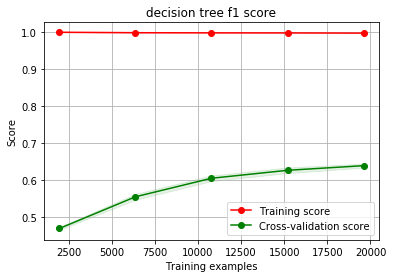

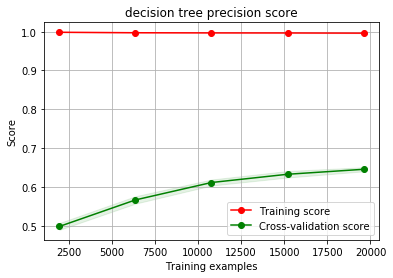

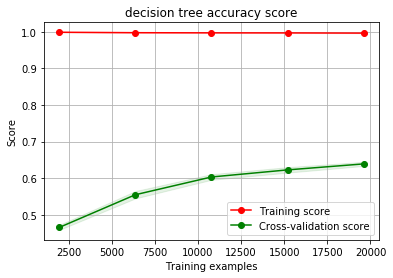

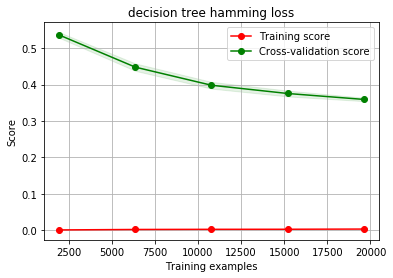

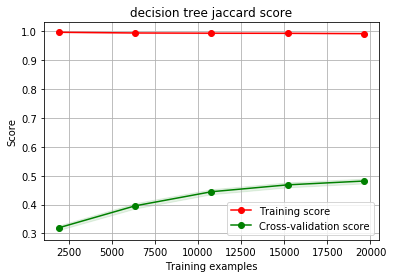

/usr/local/lib/python3.8/site-packages/matplotlib/textpath.py:90: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/local/lib/python3.8/site-packages/matplotlib/textpath.py:203: RuntimeWarning: Glyph 9 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


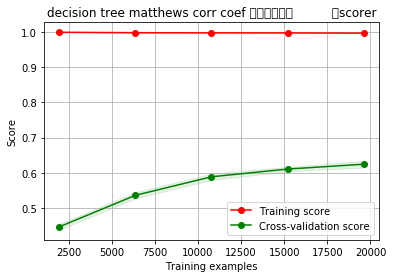

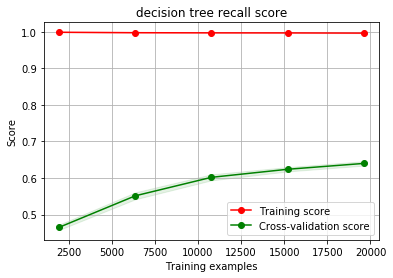

In [18]:
# muestra falta de datos
plot_learning_curve(dt_classifier, 'decision tree f1 score',
                            tfidf_uni_bigram_train, train_cats, cv=5, n_jobs=-1,                              scorer=f1_scorer)
plot_learning_curve(dt_classifier, 'decision tree precision score',
                            tfidf_uni_bigram_train, train_cats, cv=5, n_jobs=-1,                              scorer=precision_scorer)
plot_learning_curve(dt_classifier, 'decision tree accuracy score',
                            tfidf_uni_bigram_train, train_cats, cv=5, n_jobs=-1,                              scorer=accuracy_scorer)
plot_learning_curve(dt_classifier, 'decision tree hamming loss',
                            tfidf_uni_bigram_train, train_cats, cv=5, n_jobs=-1,                              scorer=hamming_losser)
plot_learning_curve(dt_classifier, 'decision tree jaccard score',
                            tfidf_uni_bigram_train, train_cats, cv=5, n_jobs=-1,                              scorer=jaccard_scorer)
plot_learning_curve(dt_classifier, 'decision tree matthews corr coef 						          	scorer', tfidf_uni_bigram_train, train_cats, cv=5,                                n_jobs=-1, scorer=matthews_corrcoef_scorer)
plot_learning_curve(dt_classifier, 'decision tree recall score',
                            tfidf_uni_bigram_train, train_cats, cv=5, n_jobs=-1,                              scorer=recall_scorer)

Otro analisis que puede realizarse es el de probar 35 iteraciones del propio clasificador, o sea, crear 35 nuevos clasificadores y probarlos obteniendo el promedio para las medidas propuestas, de esta forma nos aseguramos que nuestro clasificador para este dataset siempre tendra los valores aproximados de las medidas que hemos estado mostrando.

In [18]:
dt_classifier = DecisionTreeClassifier()

statistical_average(dt_classifier)

KeyboardInterrupt: 

# K-Nearest Neighbors

A continuacion analicemos ***KNN***. Una de las cosas interesantes al usar ***KNN*** es que no tiene mucho sentido realizar crossvalidation sobre el modelo, puesto que se estarian entrenando modelos distintos y posiblemente realizando *overfiting*, o sea, a diferencia de otros modelos como ***Decision Tree*** o ***SVM*** (Support Vector Machine) en donde se necesita crear cierta 'estructura' (el arbol o el hyperplano) a partir de los datos proporcionados, la cual sera la encargada de clasificar dichos datos, en ***KNN*** la 'estructura' son los propios datos. Si se realiza crossvalidation sobre ***KNN*** sencillamente se estarian creando una cantidad de modelos distintos, si bien dicha informacion pudiera dar una idea del comportamiento del modelo para el dataset no es necesariamente lo que estamos buscando. Lo que si pudieramos realizar es un crossvalidation pero para buscar el mejor *K*, o sea, encontrar el hyperparametro de nuestro modelo, notar la leve diferencia, mientras se usa crossvalidation en otros modelos para estimar cuan bueno son, o mejorar su potencial, en nuestro caso sencillamente lo usaremos como una busqueda del hyperparametro (en otros modelos como ***SVM*** tambien se realiza esta busqueda). En el caso de ***KNN*** la idea seria para cada valor a probar del hyperparametro realizar crossvalidation y quedarnos con el valor cuyo promedio de pecision para el crossvalidation haya sido el mejor, o sea, para cada *K* se hace crossvalidation y nos quedamos con el promedio de la presicion del crossvalidation, luego escogemos el *K* con mayor promedio. Esta idea garantiza que nuestro modelo para el dataset que estamos seleccionando contara con el mejor hyperparametro. 

> Ejercicio: Realizar ***KNN*** con una busqueda del hyperparametro con [distribucion normal][3] para los valores de *K* para el dataset.

[3]: https://en.wikipedia.org/wiki/Normal_distribution


In [19]:
from sklearn.neighbors import KNeighborsClassifier

Nuevamente creamos nuestro modelo. En este caso despues de probar realizando busquedas aleatorias se llego a la conclusion de que 30 era un buen valor para el hyperparametro *K*.

In [20]:
knn_classifier = KNeighborsClassifier(n_neighbors=30, n_jobs=-1)
knn_classifier.fit(tfidf_uni_bigram_train, train_cats)

pred_nb = knn_classifier.predict(tfidf_uni_bigram_test)

## Algunos analisis

Y probamos distinas metricas.

In [21]:
print(f1_score(test_cats, pred_nb, average='weighted'))
print(precision_score(test_cats, pred_nb, average='weighted'))
print(accuracy_score(test_cats, pred_nb))
print(hamming_loss(test_cats, pred_nb))
print(jaccard_score(test_cats, pred_nb, average='weighted'))
# val_test_log_loss = log_loss(test_cats, pred_nb)
print(matthews_corrcoef(test_cats, pred_nb))
print(recall_score(test_cats, pred_nb, average='weighted'))

0.4863114284339429
0.7862099017728191
0.4142
0.5858
0.3341890238558273
0.4471803522933679
0.4142


Igual que en el modelo anterior probaremos 35 'entrenamientos' para ***KNN*** con el fin de comprobar estadisticamente si es correcta su precision.

In [22]:
knn_classifier = KNeighborsClassifier(n_neighbors=30, n_jobs=-1)

statistical_average(knn_classifier)

KeyboardInterrupt: 

# Support Vector Machine



In [2]:
from sklearn.svm import LinearSVC
from sklearn import metrics
from scipy.stats import expon

Como habiamos hablado en la seccion anterior en el caso de ***SVM*** podemos realizar una busqueda en el espacio del hyperparametro. En este caso vamos a realizar una busqueda aleatoria (los valores del hyperparametro seran seleccionados aleatoriamente utilizando una [distribucion exponencial][4]), esto para evitar demorarnos demasiado buscando valores y el consumo excesivo de recursos de la laptop, sin embargo, una busqueda completa seria lo mejor, pero se necesitaria una maquina mas potente.

> Ejercicio: realizar una busqueda mas completa de los valores del hyperparametro.

[4]: https://en.wikipedia.org/wiki/Exponential_distribution

In [17]:
svm_classifier = LinearSVC(max_iter=5000, dual=False)

param_space = {'C': expon(scale=0.1)}

ran_search = RandomizedSearchCV(svm_classifier,
								param_distributions=param_space, n_iter=200,
								n_jobs=4, cv=5, scoring=f1_scorer)
ran_search.fit(tfidf_uni_bigram_train, train_cats)

best_svm = ran_search.best_estimator_

pred_nb = best_svm.predict(tfidf_uni_bigram_test)

KeyboardInterrupt: 

## Algunos analisis

Igual que en los casos anteriores realizamos los analisis de las metricas.

In [ ]:
print(f1_score(test_cats, pred_nb, average='weighted'))
print(precision_score(test_cats, pred_nb, average='weighted'))
print(accuracy_score(test_cats, pred_nb))
print(hamming_loss(test_cats, pred_nb))
print(jaccard_score(test_cats, pred_nb, average='weighted'))
# val_test_log_loss = log_loss(test_cats, pred_nb)
print(matthews_corrcoef(test_cats, pred_nb))
print(recall_score(test_cats, pred_nb, average='weighted'))

Se analizan las metricas aplicadas al crossvalidation.

In [ ]:
print(mean_cross_score(best_svm, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=f1_scorer))
printmean_cross_score(best_svm, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=precision_scorer))
print(mean_cross_score(best_svm, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=accuracy_scorer))
print(mean_cross_score(best_svm, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=hamming_losser))
print(mean_cross_score(best_svm, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=jaccard_scorer))
print(mean_cross_score(best_svm, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=matthews_corrcoef_scorer))
print(mean_cross_score(best_svm, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=recall_scorer))

Posteriormente podemos visualizar las *learning curves* del modelo para el crossvalidation. Notemos que en este caso el modelo ya posee el hyperparametro que encontramos anteriormente.

In [ ]:
plot_learning_curve(best_svm, ' f1 score',
						  tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=f1_scorer)
plot_learning_curve(best_svm, 'best svm precision score',
						  tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=precision_scorer)
plot_learning_curve(best_svm, 'best svm accuracy score',
						  tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=accuracy_scorer)
plot_learning_curve(best_svm, 'best svm hamming loss',
						  tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=hamming_losser)
plot_learning_curve(best_svm, 'best svm jaccard score',
						  tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=jaccard_scorer)
plot_learning_curve(best_svm, 'best svm matthews corr coef scorer',                                         tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1,
						  scorer=matthews_corrcoef_scorer)

Y nuevamente evaluamos para 35 iteraciones realizando cross validation.

In [ ]:
statistical_average(best_svm)

En general el modelo de ***SVM*** es el que mejor se ha comportado, por supuesto en el estado del arte tambien es el mejor teniendo en cuenta la representacion usada. Notar que no estamos tratando con representaciones de redes neuronales, si fuera el caso evidentemente que las redes superarian el modelo ***SVM***. Algunas ideas que se pueden seguir para mejorar estos modelos es utilzar algun metodo de *ensemble learning* (*meta-learning*) por ejemplo ***AdaBoost***.

> Ejercicio: Utilizar ***[AdaBoost][5]*** o algun otro metodo de *ensemble learning* para mejorar.

[5]: https://en.wikipedia.org/wiki/AdaBoost

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

En este caso usaremos *random forest* un *ensemble method*.

In [24]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(tfidf_uni_bigram_train, train_cats)

pred_nb = rf.predict(tfidf_uni_bigram_test)

/usr/local/lib/python3.8/site-packages/sklearn/ensemble/forest.py:244: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  warn("The default value of n_estimators will change from "


# Algunos analisis

Como siempre analizamos algunas metricas

In [25]:
print(f1_score(test_cats, pred_nb, average='weighted'))
print(precision_score(test_cats, pred_nb, average='weighted'))
print(accuracy_score(test_cats, pred_nb))
print(hamming_loss(test_cats, pred_nb))
print(jaccard_score(test_cats, pred_nb, average='weighted'))
# val_test_log_loss = log_loss(test_cats, pred_nb)
print(matthews_corrcoef(test_cats, pred_nb))
print(recall_score(test_cats, pred_nb, average='weighted'))

0.7302667894955486
0.7326093190003369
0.7324
0.2676
0.5865880225809824
0.7234994836317844
0.7324


In [26]:
print(mean_cross_score(rf, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=f1_scorer))
print(mean_cross_score(rf, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=precision_scorer))
print(mean_cross_score(rf, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=accuracy_scorer))
print(mean_cross_score(rf, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=hamming_losser))
print(mean_cross_score(rf, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=jaccard_scorer))
print(mean_cross_score(rf, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=matthews_corrcoef_scorer))
print(mean_cross_score(rf, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=recall_scorer))

0.7049183139589601
0.7066962423166924
0.707000021056414
0.29197961830161906
0.5556041413888604
0.6991212141944166
0.7072938321753308


Mostramos las *learning curves*.

In [ ]:
plot_learning_curve(rf, 'random forest f1 score', tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=f1_scorer)
plot_learning_curve(rf, 'random forest precision score', tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=precision_scorer)
plot_learning_curve(rf, 'random forest accuracy score', tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=accuracy_scorer)
plot_learning_curve(rf, 'random forest hamming loss', tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=hamming_losser)
plot_learning_curve(rf, 'random forest jaccard score', tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=jaccard_scorer)

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)

statistical_average(rt)

# Naive Bayes

In [27]:
from sklearn.naive_bayes import MultinomialNB

> Ejercicio: probar varios tamanos de *feature vectors* para ver si *Naive Bayes* mejora.

In [28]:
naive_bayes = MultinomialNB()
naive_bayes.fit(tfidf_uni_bigram_train, train_cats)

pred_nb = naive_bayes.predict(tfidf_uni_bigram_test)

# Algunos analisis

In [29]:
print(f1_score(test_cats, pred_nb, average='weighted'))
print(precision_score(test_cats, pred_nb, average='weighted'))
print(accuracy_score(test_cats, pred_nb))
print(hamming_loss(test_cats, pred_nb))
print(jaccard_score(test_cats, pred_nb, average='weighted'))
# val_test_log_loss = log_loss(test_cats, pred_nb)
print(matthews_corrcoef(test_cats, pred_nb))
print(recall_score(test_cats, pred_nb, average='weighted'))

0.684805535855798
0.7534710463710419
0.6882
0.3118
0.538685426001937
0.6791609212888896
0.6882
/usr/local/lib/python3.8/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,
/usr/local/lib/python3.8/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,


Mostramos las metricas aplicadas sobre el cross validation.

In [ ]:
print(mean_cross_score(naive_bayes, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=f1_scorer))
print(mean_cross_score(naive_bayes, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=precision_scorer))
print(mean_cross_score(naive_bayes, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=accuracy_scorer))
print(mean_cross_score(naive_bayes, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=hamming_losser))
print(mean_cross_score(naive_bayes, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=jaccard_scorer))
print(mean_cross_score(naive_bayes, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=matthews_corrcoef_scorer))
print(mean_cross_score(naive_bayes, tfidf_uni_bigram_train, train_cats,
							 cv=5, n_jobs=-1, scoring=recall_scorer))

Mostramos las *learning curves*.

In [ ]:
plot_learning_curve(naive_bayes, 'naive bayes f1 score',
						  tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=f1_scorer)plot_learning_curve(naive_bayes, 'naive bayes precision score',
						  tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=precision_scorer)
plot_learning_curve(naive_bayes, 'naive bayes accuracy score',
						  tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=accuracy_scorer)
plot_learning_curve(naive_bayes, 'naive bayes hamming loss',
						  tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=hamming_losser)
plot_learning_curve(naive_bayes, 'naive bayes jaccard score',
						  tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1, scorer=jaccard_scorer)
plot_learning_curve(naive_bayes, 'naive bayes matthews corr coef scorer',                                   tfidf_uni_bigram_train,
						  train_cats, cv=5, n_jobs=-1,
						  scorer=matthews_corrcoef_scorer)

Probamos que las metricas den un resultado estadisticamente correcto.

In [ ]:
naive_bayes = MultinomialNB()

statistical_average(naive_bayes)

# K Means

Se intentaron varios experimentos con  ***K Means***, sin embargo, el problema de [la maldicion de las altas dimensiones][9] impidio que los resultados fueran alentadores. La forma mas simple que se puede utilizar para realizar clasificacion con ***K Means*** (ver `kmeans.py`) es aplicarlo sobre el train set, con un numero de clusters igual a la cantidad de categorias que se desea clasificar. Luego a cada cluster se le pone como categoria la categoria mas repetida de los *samples* que se encuentran en el mismo, posteriormente podemos aplicar las metricas normalmente, un ejemplo de este codigo puede ser visto en el archivo `kmeans.py`. 

[9]: https://en.wikipedia.org/wiki/Curse_of_dimensionality

> Ejercicio: tratar de eliminar el problema de la maldicion de las altas dimensiones reduciendo la cantidad de palabras utilizadas.

> Ejercicio: tratar de eliminar el problema de la maldicion de las altas dimensiones utilizando alguna tecnica de reduccion de dimensiones como [Principal Component Analysis][6] (*PCA*), alguna otra tecnica [*manifold*][7], [mapas de Kohonen][8] o cualquier otra.

[6]: https://en.wikipedia.org/wiki/Principal_component_analysis
[7]: https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction
[8]: https://en.wikipedia.org/wiki/Self-organizing_map

> Nota: notemos que el dataset no esta balanceado, o sea, cada categoria no cuenta con igual numeros de *samples*, esto es lo que provoca que nuestros modelos se comporten mejor para unas categorias que para otras.

> Ejercicio: crear un dataset balanceado y realizar todo el analisis nuevamente.